### 1. Importing Libraries and Modules

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf
import tensorflow_datasets as tfds

import config as conf

from PIL import Image

from models.wgan import WGAN

### 2. Loading MNIST Dataset and Training Results

In [2]:
loader, info = tfds.load(conf.DATASET, in_memory=True, with_info=True)
train_loader = loader["test"].repeat().shuffle(1024).batch(conf.BATCH_SIZE)

feature_shape = info.features["image"].shape
feature_depth = np.prod(feature_shape)

latent_depth = conf.LATENT_DEPTH

model_rslt_name = "%s-results.pickle" % conf.MODEL_NAME

model_save_path = os.path.join(conf.MODEL_SAVE_DIR, conf.MODEL_NAME)
model_rslt_path = os.path.join(model_save_path, model_rslt_name)

with open(model_rslt_path, "rb") as f:
    generator_loss_mean, discriminator_loss_mean, gs = pickle.load(f)

### 3. Ploting the Generator and Discriminator Losses

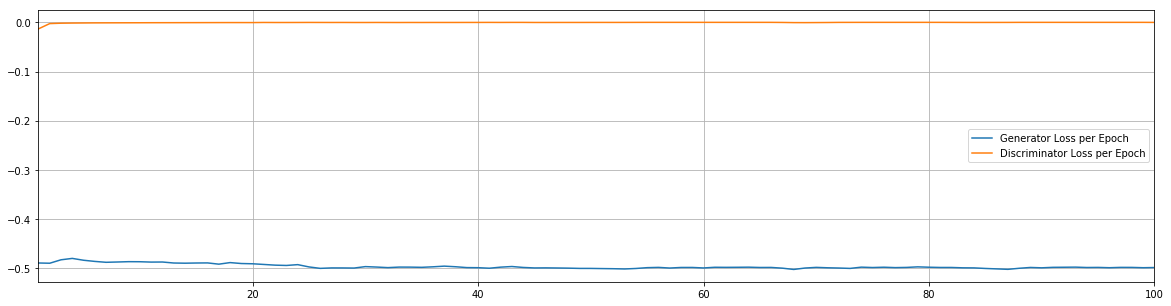

In [3]:
t = np.arange(1, len(generator_loss_mean)+1)
plt.figure(figsize=[20, 5], facecolor="white")
plt.plot(t, generator_loss_mean, label="Generator Loss per Epoch")
plt.plot(t, discriminator_loss_mean, label="Discriminator Loss per Epoch")
plt.xlim(1, conf.NUM_EPOCHS)
plt.grid()
plt.legend()
plt.show()

### 4. Image Generation Results

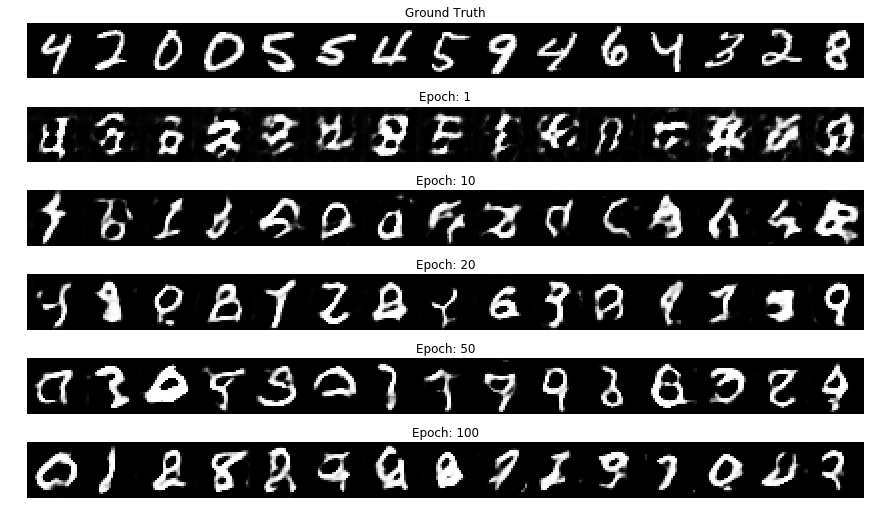

In [4]:
view_list = [1, 10, 20, 50, 100]
view_range = 15 # Should be less than conf.BATCH_SIZE

for x in train_loader.take(1):
    ground_truth = x["image"]

fig, axs = plt.subplots(nrows=1+len(view_list), figsize=[view_range, int((len(view_list)+1)*1.5)], facecolor="white")
axs[0].imshow(np.hstack(ground_truth[:view_range, :, :, 0]), cmap="gray")
axs[0].set_title("Ground Truth")
axs[0].axis("off")

for i, idx in enumerate(view_list, 1):
    g = gs[idx-1]
    axs[i].imshow(np.hstack(g[:view_range, :, :, 0]), cmap="gray")
    axs[i].set_title("Epoch: %i" % idx)
    axs[i].axis("off")
    
plt.savefig(os.path.join(model_save_path, "image_generation_results.png"))

### 5. Loading Checkpoint

In [5]:
model_save_path = os.path.join(conf.MODEL_SAVE_DIR, conf.MODEL_NAME)
model_ckpt_path = os.path.join(model_save_path, "model-ckpt")

model = WGAN(
    project_shape=conf.HYPARAMS[conf.DATASET]["project_shape"],
    gen_filters_list=conf.HYPARAMS[conf.DATASET]["gen_filters_list"],
    gen_strides_list=conf.HYPARAMS[conf.DATASET]["gen_strides_list"],
    disc_filters_list=conf.HYPARAMS[conf.DATASET]["disc_filters_list"],
    disc_strides_list=conf.HYPARAMS[conf.DATASET]["disc_strides_list"]
)

ckpt = tf.train.Checkpoint(generator=model.generator, discriminator=model.discriminator)

ckpt.restore(tf.train.latest_checkpoint(model_save_path))

### 6. Random Image Generation

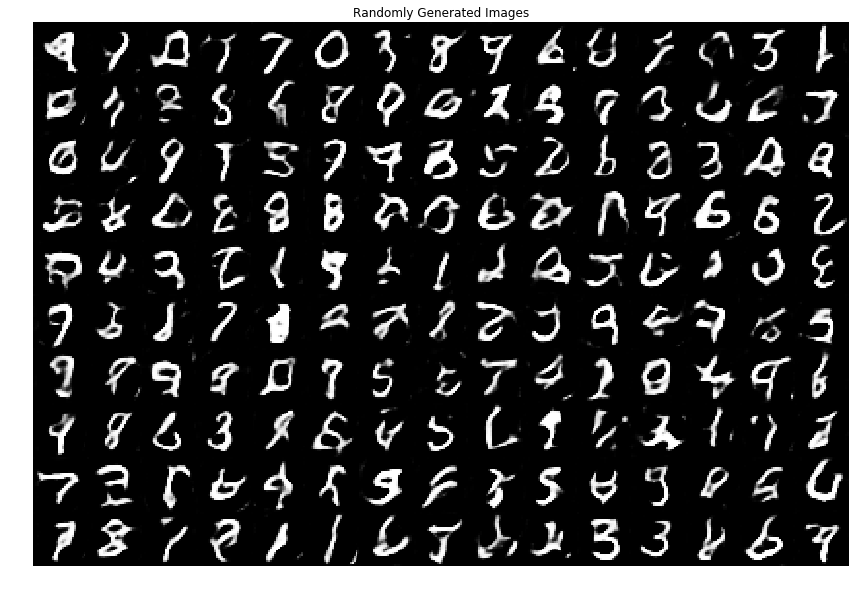

In [6]:
z = np.random.normal(size=[150, latent_depth]).astype(np.float32)
x = model.generator(z, training=False)

plt.figure(figsize=[15, 10], facecolor="white")
plt.imshow(np.hstack(np.hstack(np.reshape(x, newshape=[10, 15]+list(feature_shape))[:, :, :, :, 0])), cmap="gray")
plt.axis("off")
plt.title("Randomly Generated Images")

plt.savefig(os.path.join(model_save_path, "randomly_generated_images.png"))

### 7. Image Generation Result Changes

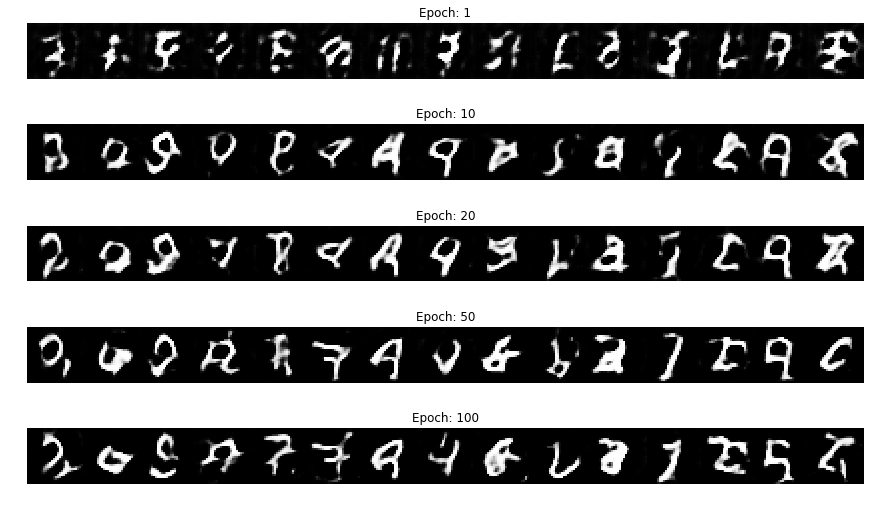

In [7]:
z = np.random.normal(size=[view_range, latent_depth]).astype(np.float32)

fig, axs = plt.subplots(nrows=len(view_list), figsize=[view_range, int((len(view_list)+1)*1.5)], facecolor="white")
for i, idx in enumerate(view_list):
    model_ckpt_path = os.path.join(model_save_path, "model-ckpt-%i" % idx)
    ckpt.restore(model_ckpt_path)
    x = model.generator(z, training=False)
    x = np.reshape(x, newshape=[-1]+list(feature_shape))
    
    axs[i].imshow(np.hstack(x[:, :, :, 0]), cmap="gray")
    axs[i].set_title("Epoch: %i" % idx)
    axs[i].axis("off")
    
plt.savefig(os.path.join(model_save_path, "image_generation_result_changes.png"))

In [8]:
gif_path = "./assets/img/result_plot/image_generation_result_changes.gif"

if not os.path.exists(gif_path):
    z = np.random.normal(size=[150, latent_depth]).astype(np.float32)

    frames = []
    for i in range(conf.NUM_EPOCHS):
        model_ckpt_path = os.path.join(model_save_path, "model-ckpt-%i" % (i+1))
        ckpt.restore(model_ckpt_path)
        x = model.generator(z, training=False)

        fig = plt.figure(figsize=[15, 10], facecolor="white")

        plt.imshow(np.hstack(np.hstack(np.reshape(x, newshape=[10, 15]+list(feature_shape))[:, :, :, :, 0])), cmap="gray")
        plt.title("Epoch: %i" % (i+1))
        plt.axis("off")

        canvas = plt.get_current_fig_manager().canvas
        canvas.draw()

        pil_image = Image.frombytes("RGB", canvas.get_width_height(), canvas.tostring_rgb())

        frames.append(pil_image)

        plt.close()
    
    frames[0].save(
        gif_path,
        format="GIF",
        append_images=frames[1:],
        save_all=True,
        duration=100,
        loop=0
    )

In [9]:
display.Image(url=gif_path)